In [171]:
%reset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import optimizers

In [2]:
# Dataset from github repo: https://github.com/sidk003/Stock-Market-Prediction/tree/master/stock_price_prediction/       company_stock_prices

aapl_url = 'https://raw.githubusercontent.com/sidk003/Stock-Market-Prediction/master/stock_price_prediction/company_stock_prices/AAPL.csv'
amzn_url = 'https://raw.githubusercontent.com/sidk003/Stock-Market-Prediction/master/stock_price_prediction/company_stock_prices/AMZN.csv'
fb_url = 'https://raw.githubusercontent.com/sidk003/Stock-Market-Prediction/master/stock_price_prediction/company_stock_prices/FB.csv'
msft_url = 'https://raw.githubusercontent.com/sidk003/Stock-Market-Prediction/master/stock_price_prediction/company_stock_prices/MSFT.csv'

In [3]:
# CSV -> pandas dataframe

aapl_closing_price = pd.read_csv(aapl_url, usecols=['Date', 'Close'])
amzn_closing_price = pd.read_csv(amzn_url, usecols=['Date', 'Close','Volume'])
fb_closing_price = pd.read_csv(fb_url, usecols=['Date', 'Close'])
msft_closing_price = pd.read_csv(msft_url, usecols=['Date', 'Close'])

In [4]:
# Importing sentiment dataset AMZN and preprocessing df

amzn_sentiment_url = 'https://raw.githubusercontent.com/sidk003/Stock-Market-Prediction/master/stock_price_prediction/company_stock_prices/AMZN2019_sentiments.csv'
amzn_sentiment_df = pd.read_csv(amzn_sentiment_url, usecols=['Date', 'Sentiment'],  encoding='latin-1')

# Converting string to datetime
amzn_sentiment_df['Date'] = pd.to_datetime(amzn_sentiment_df['Date'], format="%Y-%m-%d %H:%M:%S-%I:%f", errors='coerce')

In [5]:
# Importing sentiment dataset AAPL
aapl_sentiment_url = 'https://raw.githubusercontent.com/sidk003/Stock-Market-Prediction/master/stock_price_prediction/company_stock_prices/APPL2019News.csv'
aapl_sentiment_df = pd.read_csv(aapl_sentiment_url, usecols=['published', 'sentiment'], encoding='latin-1')

# Renaming columns
aapl_sentiment_df.rename(columns = {'published':'Date'}, inplace = True)
aapl_sentiment_df.rename(columns = {'sentiment':'Sentiment'}, inplace = True)

# Converting string to datetime
aapl_sentiment_df['Date'] = pd.to_datetime(aapl_sentiment_df['Date'], format="%Y-%m-%dT%H:%M:%SZ", errors='coerce')
aapl_sentiment_df.head()

,Date,Sentiment
0,2019-12-31 21:17:13,0.42
1,2019-12-31 21:23:00,0.81
2,2019-12-31 22:32:36,0.94
3,2019-12-31 22:51:07,0
4,2019-12-31 22:55:11,0.38


In [6]:
ticker = 'AMZN'

if ticker == 'AMZN':
  sentiment_df = amzn_sentiment_df
  closing_price_df = amzn_closing_price
  name = 'Amazon'
elif ticker == 'AAPL':
  sentiment_df = aapl_sentiment_df
  closing_price_df = aapl_closing_price
  name = 'Apple'

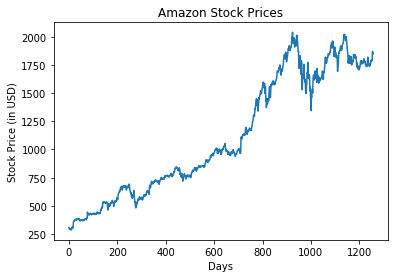

In [7]:
plt.plot(closing_price_df['Close'])
plt.xlabel("Days")
plt.ylabel("Stock Price (in USD)")
plt.title(str(name) + " Stock Prices")
plt.show()

In [8]:
# function to get average of sentiment on each day
def get_average_df(df):
  # Converting sting Sentiments to float
  df['Sentiment'] = pd.to_numeric(df['Sentiment'],errors='coerce')
  df.dropna()
  # calculating average by mean()
  df = df.groupby(df.Date.dt.date).mean().reset_index()
  return df

In [9]:
# Run only once 
sentiment_df = get_average_df(sentiment_df)
sentiment_df.head()

,Date,Sentiment
0,2019-01-02,0.668783
1,2019-01-03,0.996000
2,2019-01-04,0.387600
3,2019-01-06,0.972500
4,2019-01-07,0.441140


In [10]:
# converting both df to same datetime format
def combine_df(df1,df2):
  df1.Date = pd.to_datetime(df1.Date)
  df2.Date = pd.to_datetime(df2.Date)
  df = pd.merge(df1, df2, on='Date')
  return df

In [11]:
df = combine_df(closing_price_df, sentiment_df)
original_df = df.copy()
df.head()

,Date,Close,Volume,Sentiment
0,2019-01-02,1539.130005,7983100,0.668783
1,2019-01-03,1500.280029,6975600,0.996000
2,2019-01-04,1575.390015,9182600,0.387600
3,2019-01-07,1629.510010,7993200,0.441140
4,2019-01-08,1656.579956,8881400,0.432075


In [12]:
scaler = MinMaxScaler()
df[['Close']] = scaler.fit_transform(df[['Close']])

volume_scaler = MinMaxScaler()
df[['Volume']] = volume_scaler.fit_transform(df[['Volume']])

scaler_sentiment = MinMaxScaler()
df[['Sentiment']] = scaler_sentiment.fit_transform(df[['Sentiment']])

df.head()

,Date,Close,Volume,Sentiment
0,2019-01-02,0.074610,0.668411,0.716533
1,2019-01-03,0.000000,0.573587,0.998021
2,2019-01-04,0.144245,0.781306,0.474644
3,2019-01-07,0.248180,0.669362,0.520702
4,2019-01-08,0.300167,0.752958,0.512904


In [13]:
# 70-30 split
train_data, test_data = np.split(df, [int(0.7*len(df))])

In [14]:
# pd dataframe to np array for slicing and reshaping
features = ['Close', 'Sentiment', 'Volume']
train_data = train_data[features].to_numpy()
test_data =  test_data[features].to_numpy()

print('FEATURE LIST')
print([f for f in features])

In [15]:
def create_dataset(dataset, timestep = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - timestep - 1):
        data_x.append(dataset[i: (i+timestep), :])
        data_y.append(dataset[i + timestep, 0])
    return np.array(data_x), np.array(data_y)

In [16]:
timestep = 1
train_x, train_y = create_dataset(train_data, timestep)
test_x, test_y = create_dataset(test_data, timestep)

train_x = np.reshape(train_x, (train_x.shape[0], timestep, train_x.shape[2]))
test_x = np.reshape(test_x, (test_x.shape[0], timestep, test_x.shape[2]))

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

In [19]:
def create_model():
    model = Sequential()
    model.add(LSTM(256, input_shape=(1, len(features))))
    model.add(Dense(1,activation='sigmoid'))
    optimizers.Adam(lr=0.0001)  
    return model

In [20]:
def compile_and_run(model, epochs, batch_size):
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1)
    score = model.evaluate(train_x, train_y, verbose=1)
    return history, score

In [21]:
def plot_metrics(history):
    metrics_df = pd.DataFrame(data={"loss": history.history['loss']})
    metrics_df.plot()
    plt.xlabel("No. of Epochs")
    plt.ylabel("Loss")

In [22]:
LSTM_model = create_model()
print(LSTM_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               266240    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 266,497
Trainable params: 266,497
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
history, score = compile_and_run(LSTM_model, epochs=100, batch_size=64) 
print('Keras model loss = ', score[0])
print('Keras model accuracy = ', score[1])

Epoch 1/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0541 - accuracy: 0.0058
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0524 - accuracy: 0.0058
Epoch 3/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0507 - accuracy: 0.0058
Epoch 4/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0494 - accuracy: 0.0058
Epoch 5/100
3/3 [==============================] - 0s 6ms/step - loss: 0.0483 - accuracy: 0.0058
Epoch 6/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0474 - accuracy: 0.0058
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0468 - accuracy: 0.0058
Epoch 8/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0460 - accuracy: 0.0058
Epoch 9/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0455 - accuracy: 0.0058
Epoch 10/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0450 - accuracy: 0.0058
Epoch 11/100
3/3 [==========

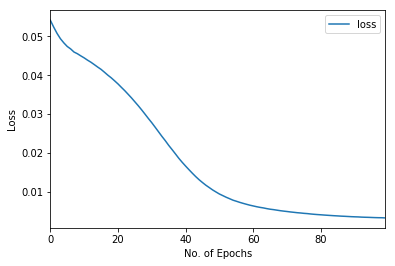

In [24]:
plot_metrics(history)

In [25]:
train_predictions = LSTM_model.predict(train_x)
test_predictions = LSTM_model.predict(test_x)

In [26]:
# Applying inverse transform to get the values back
train_predictions = scaler.inverse_transform(train_predictions)
train_y = scaler.inverse_transform([train_y])

test_predictions = scaler.inverse_transform(test_predictions)
test_y = scaler.inverse_transform([test_y])

In [27]:
train_predict_plot = np.empty_like(df)
train_predict_plot[:,:] = np.nan
train_predict_plot[1:len(train_predictions)+1, :] = train_predictions

test_predict_plot = np.empty_like(df)
test_predict_plot[:,:] = np.nan
test_predict_plot[len(train_predictions)+1 : len(df)-3, :] = test_predictions

In [28]:
test_predictions = test_predictions.flatten()
train_prices, test_prices = np.split(original_df, [int(0.7*len(original_df))])

train_prices = train_prices['Close'].to_numpy()
test_prices =  test_prices['Close'].to_numpy()
test_prices = test_prices[:-2].copy()

actual_stock_prices = np.concatenate((train_prices, test_prices))

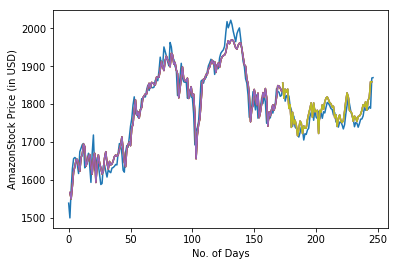

In [29]:
actual_stock_prices = plt.plot(actual_stock_prices, label='Actual Stock Prices')
train_dataset_prediction = plt.plot(train_predict_plot, label='Train dataset predictions')
test_dataset_prediction = plt.plot(test_predict_plot, label='Test dataset predictions')

# plt.legend(handles = [actual_stock_prices, train_dataset_prediction, test_dataset_prediction])
plt.xlabel("No. of Days")
plt.ylabel(str(name) + "Stock Price (in USD)")
plt.show()

In [30]:
def get_error_scores(y_test,y_pred):
  mse = mean_squared_error(y_test,y_pred)
  rmse = math.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  return mse, rmse, mae

In [31]:
mse, rmse, mae = get_error_scores(test_prices, test_predictions)
print('Mean Squared Error: %.3f' % mse)
print('Root Mean Squared Error: %.3f' % rmse)
print('Mean Average Error: %.3f' % mae)

Mean Squared Error: 214.921
Root Mean Squared Error: 14.660
Mean Average Error: 13.293


In [32]:
df = pd.DataFrame({'Actual Values': test_prices, 'Predicted Values':test_predictions})
df.head(10)

,Actual Values,Predicted Values
0,1839.339966,1855.622070
1,1807.839966,1815.444214
2,1822.550049,1839.386719
3,1817.459961,1831.729736
4,1821.500000,1839.653442
5,1794.160034,1788.712524
6,1785.300049,1798.504517
7,1741.609985,1738.764526
8,1768.329956,1778.623657
9,1739.839966,1747.714478


Text(0,0.5,'Stock Price (in USD)')

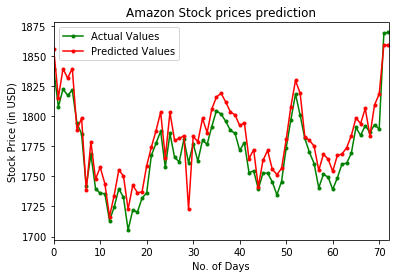

In [33]:
plot = df[['Actual Values', 'Predicted Values']].plot( marker='.',
                                                color=['green', 'red'], 
                                                title= str(name) + " Stock prices prediction")
                                                
plot.set_xlabel("No. of Days")
plot.set_ylabel("Stock Price (in USD)")

In [34]:
new_df = df.copy()
new_df = new_df.truncate(after = 10)
new_df

,Actual Values,Predicted Values
0,1839.339966,1855.622070
1,1807.839966,1815.444214
2,1822.550049,1839.386719
3,1817.459961,1831.729736
4,1821.500000,1839.653442
5,1794.160034,1788.712524
6,1785.300049,1798.504517
7,1741.609985,1738.764526
8,1768.329956,1778.623657
9,1739.839966,1747.714478


Text(0,0.5,'Stock Price (in USD)')

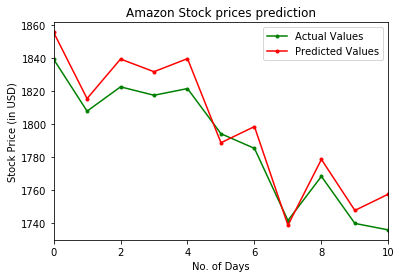

In [35]:
plot = new_df[['Actual Values', 'Predicted Values']].plot( marker='.',
                                                color=['green', 'red'], 
                                                title= str(name) + " Stock prices prediction")
                                                
plot.set_xlabel("No. of Days")
plot.set_ylabel("Stock Price (in USD)")